In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from keras.preprocessing.image import ImageDataGenerator 
import cv2

from scipy import ndimage
#import seaborn as sns
#sns.set(color_codes=True)

Using TensorFlow backend.


In [1]:
plt.matshow(train_images[0,:,:,2].reshape(75,75))

NameError: name 'plt' is not defined

In [ ]:
# plt.matshow(iso(train_images[8,:,:,0]))


In [2]:
# import json

# Isolation function.
def iso(arr):
    p = arr > (np.mean(np.array(arr))+2*np.std(np.array(arr)))
    p= ndimage.binary_opening(p,structure=np.ones((2)))
    return p * arr
# Size in number of pixels of every isolated object.
def size(arr):     
    arr = iso(arr)
    return np.sum(np.array(arr)<-5)

def load_and_format(in_path):
    out_df = pd.read_json(in_path)  
    out_images = out_df.apply(lambda c_row: [np.stack([c_row['band_1'],c_row['band_2'],np.add(c_row['band_1'],c_row['band_2'])/2], -1).reshape((75,75,3))],1)
    out_images = np.stack(out_images).squeeze()
    #out_images[:,:,:,0] = (out_images[:,:,:,0]-out_images[:,:,:,0].min())/(out_images[:,:,:,0].max()-out_images[:,:,:,0].min())   train_df['band_1'].apply(iso)
    #out_images[:,:,:,1] = (out_images[:,:,:,1]-out_images[:,:,:,1].min())/(out_images[:,:,:,1].max()-out_images[:,:,:,1].min())     ,np.add(c_row['band_1'],c_row['band_2'])/2]
    #out_images[:,:,:,2] = (out_images[:,:,:,2]-out_images[:,:,:,2].min())/(out_images[:,:,:,2].max()-out_images[:,:,:,2].min())
    return out_df, out_images
train_df, train_images = load_and_format('data/train.json')
train_df['sum'] = train_df['band_1'].apply(size)
print("min:",train_df['sum'].min(),  " Max:",train_df['sum'].max()," mean:",train_df['sum'].mean())
train_df['sum'] = (train_df['sum']-train_df['sum'].min())/(train_df['sum'].max()-train_df['sum'].min() )*2.5

print('training', train_df.shape, 'loaded', train_images.shape)

min: 0  Max: 272  mean: 73.8447630923
training (1604, 6) loaded (1604, 75, 75, 3)


In [3]:
def plot_list(arr):
    fig = plt.figure()
    gs1 = gridspec.GridSpec(len(arr),1)
    for idx,ar in zip(range(len(arr)),arr):        
        ax = fig.add_subplot(gs1[idx])
        ax.plot(ar)
        
    gs1.tight_layout(fig)
    
################### Devesh DataAugmentation
def collage(img):    
    vis = np.concatenate((img,img), axis=0)
    vis2 = np.concatenate((vis,vis), axis=1)
    vis2 = vis2[25:150,25:150].copy()
    vis2 = cv2.resize(vis2, (75,75))
    return vis2

def add_salt_and_pepper(img, prob = 0.22):
    '''Adds "Salt & Pepper" noise to an image.
    gb: should be one-channel image with pixels in [0, 1] range
    prob: probability (threshold) that controls level of noise'''
    mean = 0
    sigma = 2
    im = np.zeros_like(img)
    cv2.randn(im,mean,sigma) # create the random distribution
    Fruit_Noise = cv2.add(img, im) # add the noise to the original image
    return Fruit_Noise


def makeMult(function,data, to_conc):
    new_data=np.empty_like(data)
    for i in range(0,len(data)):
        new_data[i,:,:,:]=function(data[i,:,:,:])
        
    return np.concatenate((to_conc, new_data), axis=0)

###########
    
import tensorflow as tf
def create_placeholders():
     ###place holders 
    global input_,input_post,label,keep_prob,is_train
    input_ = tf.placeholder(tf.float32, (None, 75, 75,3), name = 'features')
    input_post = tf.placeholder(tf.float32, (None,2), name = 'features2')
    label = tf.placeholder(tf.int32, (None, 2), name = 'labels')
    keep_prob = tf.placeholder(tf.float32)
    is_train = tf.placeholder(tf.bool, name='is_train')
tf.reset_default_graph()

In [4]:
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
state=2017
X_train, X_test, y_train, y_test,train_index,test_index = train_test_split(train_images,
                                                   to_categorical(train_df['is_iceberg']),range(len(train_images)),
                                                    random_state = state,
                                                    test_size = 0.2
                                                   )
train_df['inc_angle'] =train_df['inc_angle'].replace('na',0) / 50
a = np.array([train_df['inc_angle'].values,train_df['sum']])
a = np.array([[a[0,i],a[1,i]] for i in range(len(a[0]))])  #reshaped
X_train_post,X_test_post  = train_test_split(a,random_state = state,test_size = 0.2)

'''
X_train = makeMult(add_salt_and_pepper,X_train)
y_train = np.append(y_train,y_train,axis=0)
X_train_ang = X_train_ang.append(X_train_ang)

X_train = makeMult(collage,X_train)
y_train = np.append(y_train,y_train,axis=0)
X_train_ang = X_train_ang.append(X_train_ang)
'''
half_len= int(len(X_train)/2)
print(half_len*2)
X_train_1 = makeMult(add_salt_and_pepper,X_train[:half_len],X_train)
y_train_1 = np.append(y_train,y_train[:half_len],axis=0)
X_train_post_1 = np.append(X_train_post,X_train_post[:half_len],axis = 0)

X_train = makeMult(collage,X_train[half_len:],X_train_1)
y_train = np.append(y_train_1,y_train[half_len:],axis=0)
X_train_post = np.append(X_train_post_1,X_train_post[half_len:],axis = 0)

print('Train', X_train.shape, y_train.shape)
print('Validation', X_train_post.shape, y_test.shape)

1282
Train (2566, 75, 75, 3) (2566, 2)
Validation (2566, 2) (321, 2)


In [5]:
X_train_post_1

array([[ 0.793062  ,  0.        ],
       [ 0.75375   ,  0.9375    ],
       [ 0.689442  ,  0.96507353],
       ..., 
       [ 0.804934  ,  0.34007353],
       [ 0.        ,  0.54227941],
       [ 0.891752  ,  0.30330882]])

In [6]:
def lrelu(x, n, leak=0.2): 
    return tf.maximum(x, leak * x, name=n) 
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05), name="weight")
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]), name ="bias")
def new_conv_layer(input, num_input_channels, filter_size, num_filters, num, is_train, use_pooling=True, use_bn=True
                  ):  
    
    conv = tf.layers.conv2d(input, num_filters, kernel_size=[filter_size, filter_size], strides=[1, 1], padding="SAME",
                            kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),name='conv'+str(num))
    
    if use_bn:
        conv = tf.contrib.layers.batch_norm(conv, is_training = is_train, epsilon=1e-5, decay = 0.9,  updates_collections=None, scope = 'bn'+str(num))
    
    if use_pooling:
        conv = tf.nn.max_pool(value=conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    layer = lrelu(conv, n='act'+str(num))
    return layer

## Best Hyperparameters
filter_size = [3,3,3,3,3,3]          
num_filters = [3,8,16,36,36,64,64,128]     
drop_out = [1,.75,.75,.85,.75,.65,.55]  [1,.75,.85,.90,.85,.65,.55]  
pooling = [False,True,True,True,True,True,True]
     

In [7]:
num_channels = 3
## Hyperparameters
filter_size = [3,3,3,3,3,3]          
num_filters = [3,8,16,36,36,64,64,128]     
drop_out = [1,.75,.75,.85,.75,.65,.55]
pooling = [False,True,True,True,True,True,True]
bn = [True,True,True,True,True,False,True]
# Fully-connected layer.
fc_size = 128           # Number of neurons in fully-connected layer.

In [8]:
def CNN(conv,filter_size,num_filters,drop_out):
   
    ####33##########
    #batch_norm = tf.layers.batch_normalization(x, training=is_train)
    for n in range(len(filter_size)):
        conv = new_conv_layer(input=conv,
                           num_input_channels=num_filters[n],
                           filter_size=filter_size[n],
                           num_filters=num_filters[n+1],
                           num = n, is_train = is_train,
                           use_pooling=pooling[n],
                           use_bn= bn[n])
        conv = tf.nn.dropout(conv, drop_out[n] + (1-drop_out[n])*keep_prob)
        print(conv.shape)
    # Shortcut
    #flatten_layer = tf.contrib.layers.flatten(max_pool2)
    #fc = tf.contrib.layers.full_connected(flatten_layer, 256)
    
    # Long way of doing the fully_connected_layer
    _, height, width, depth = conv.shape
    
    tensor_size = int(height * width * depth +2) 
    flatten_layer = tf.reshape(conv, [-1, tensor_size-2])
    
    fc1_hidden_unit = int(tensor_size/1.45)
    print(tensor_size)
    print(fc1_hidden_unit)
    drop_fc1 = tf.nn.dropout(flatten_layer, 0.58 + keep_prob*0.42)
    drop_feat = tf.concat( [flatten_layer, input_post ], 1 )
    W_fc1 = new_weights([tensor_size, fc1_hidden_unit])
    b_fc1 = new_biases(fc1_hidden_unit)
    
    fc1 = lrelu(tf.add(tf.matmul(drop_feat, W_fc1), b_fc1),"fc1")
    drop_fc2 = tf.nn.dropout(fc1, 0.75 + 0.25*keep_prob)   #85
    
    n_class = 2
    W_fc2 = new_weights([fc1_hidden_unit, n_class])
    b_fc2 = new_biases(n_class)
                     
    logits = tf.add(tf.matmul(drop_fc2, W_fc2), b_fc2)
    
    return logits

In [9]:
tf.reset_default_graph()
create_placeholders()
logits = CNN(input_,filter_size,num_filters,drop_out)
logits_soft =tf.nn.softmax(logits)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels = label, logits = logits)
#error = tf.square(label-logits)/2
var_s = tf.trainable_variables()
loss_l2 = tf.add_n([tf.nn.l2_loss(v) for v in var_s if 'bias' not in v.name])*0.0001
loss = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer().minimize(loss)
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(logits, 1), tf.argmax(label, 1)), tf.float32))

(?, 75, 75, 8)
(?, 38, 38, 16)
(?, 19, 19, 36)
(?, 10, 10, 36)
(?, 5, 5, 64)
(?, 3, 3, 64)
578
398


In [13]:
n_epoch = 80
batch_size =64

sess = tf.Session()
sess.run(tf.global_variables_initializer())

saver = tf.train.Saver()
best_accuracy,min_loss = 0,10
acc_rec, loss_rec, loss_train = [], [], []

datagen = ImageDataGenerator(
                            width_shift_range=0,
                            height_shift_range=0,
                            zoom_range=0.22,
                            rotation_range = 0,
                            horizontal_flip=False,
                            vertical_flip=False,
                            featurewise_center = False,
                            featurewise_std_normalization= False
                            )
                            #fill_mode='nearest')
datagen.fit(X_train)

len_train = len(y_train)
def create_batches(n_batch, batch_size = batch_size, len_ = len_train):
    idx1 = n_batch*batch_size
    idx2 = n_batch*batch_size + batch_size
    arr = list(range(len_))
    if idx2>len_:
        idx2 = len_
        return arr[idx1:idx2],False
    return arr[idx1:idx2],True

y_datagen = [[y_train[x,0],y_train[x,1],X_train_post[x,0],X_train_post[x,1]] for x in range(len(y_train))]

In [16]:
n_epoch = 80

batch_size =64
# early stopping
patience = 13
min_delta = 0.01
early_stop = False
for e in range(n_epoch):
    n_batch = 0
    status =True
    if early_stop == False:
        for x_batch, y_batch in datagen.flow(X_train, y_datagen, batch_size=batch_size):
            feed_dict = {input_: x_batch,label: y_batch[:,:2],
                                 input_post:y_batch[:,2:],keep_prob:0,is_train:True}
            _, loss_ = sess.run([optimizer, loss], feed_dict )
            train_acc = accuracy.eval(feed_dict = feed_dict,session=sess)

            if int(len_train/2) % (n_batch+1)  == 0:
                val_feed_dict = {input_: X_test,label: y_test, input_post:X_test_post.reshape([-1,2]),
                                 keep_prob:1,is_train:True }
                val_loss = sess.run(loss, feed_dict = val_feed_dict)
                val_acc = accuracy.eval(feed_dict = val_feed_dict,session=sess)
                acc_rec.append(val_acc)
                loss_rec.append(val_loss)
                loss_train.append(loss_)
                if val_acc > best_accuracy:
                    best_accuracy = val_acc
                    saver.save(sess, 'models/my_model_acc')
                    imp_str_acc = '*'*4
                    patience_cnt = 0
                else:
                    imp_str_acc = ''
                    patience_cnt +=1

                if val_loss<min_loss:
                    min_loss = val_loss
                    saver.save(sess, 'models/my_model_loss')
                    imp_str_loss = '*'*4
                else:
                    imp_str_loss = ''

                msg = "Epoch {}   Train Acc: {:.2}  Valditaion Loss: {:.3}{}, Validation Accuracy: {:.3}{}"
                print(msg.format(e, train_acc, val_loss,imp_str_loss, val_acc, imp_str_acc))
            n_batch +=1
            if patience_cnt > patience and False:
                print("early stopping...")
                early_stop = True
                break
            elif n_batch*batch_size>len_train:
                break


Epoch 0   Train Acc: 0.52  Valditaion Loss: 1.28****, Validation Accuracy: 0.502****
Epoch 1   Train Acc: 0.81  Valditaion Loss: 0.519****, Validation Accuracy: 0.72****
Epoch 2   Train Acc: 0.69  Valditaion Loss: 0.573, Validation Accuracy: 0.745****
Epoch 3   Train Acc: 0.75  Valditaion Loss: 0.391****, Validation Accuracy: 0.807****
Epoch 4   Train Acc: 0.78  Valditaion Loss: 0.386****, Validation Accuracy: 0.813****
Epoch 5   Train Acc: 0.84  Valditaion Loss: 0.391, Validation Accuracy: 0.832****
Epoch 6   Train Acc: 0.78  Valditaion Loss: 0.396, Validation Accuracy: 0.835****
Epoch 7   Train Acc: 0.88  Valditaion Loss: 0.384****, Validation Accuracy: 0.829
Epoch 8   Train Acc: 0.92  Valditaion Loss: 0.364****, Validation Accuracy: 0.844****
Epoch 9   Train Acc: 0.88  Valditaion Loss: 0.27****, Validation Accuracy: 0.891****
Epoch 10   Train Acc: 0.89  Valditaion Loss: 0.326, Validation Accuracy: 0.869
Epoch 11   Train Acc: 0.92  Valditaion Loss: 0.327, Validation Accuracy: 0.879
E

KeyboardInterrupt: 

best Acc: 0.938, Min loss: 0.175


<IPython.core.display.Javascript object>


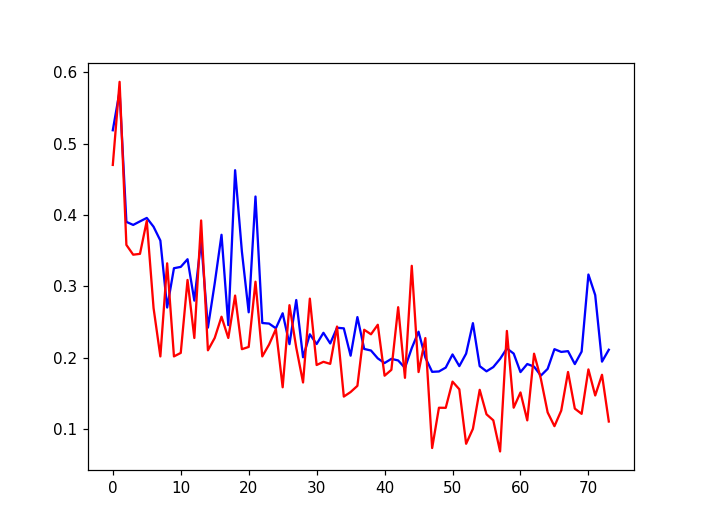

<IPython.core.display.Javascript object>


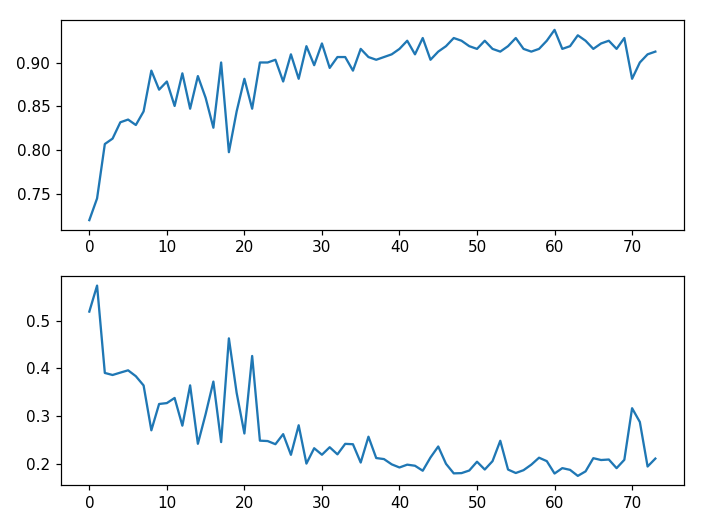

In [17]:
%matplotlib notebook
print('best Acc: {:.3}, Min loss: {:.3}'.format(best_accuracy,min_loss))
plt.plot(loss_rec[1:],'b')
plt.plot(loss_train[1:],'r')
plot_list([acc_rec[1:],loss_rec[1:]])

In [18]:
acc_rec_list = np.array(loss_rec)
acc_rec_list[acc_rec[:]==max(acc_rec)]

array([ 0.18000272], dtype=float32)

In [19]:
np.floor(1.8)

1.0

In [15]:
def predict_batch(test_imgages,inc_ang,length = 1000):
    prev_index = 0
    for x in range(int(np.floor(len(inc_ang)/length))):
        index = (x+1) * length
        feed_dict_sub = {input_: test_imgages[prev_index:index], input_post:inc_ang[prev_index:index], keep_prob:1,is_train:False} 
        
        
        pred = sess.run(logits_soft,feed_dict=feed_dict_sub)
        if x == 0:
            return_sub = pred
        else:
            return_sub = np.concatenate((return_sub,pred))
        prev_index = index
    feed_dict_sub = {input_: test_imgages[prev_index:], input_post:inc_ang[prev_index:], keep_prob:1,is_train:False} 
    pred = sess.run(logits_soft,feed_dict=feed_dict_sub)
    return_sub = np.concatenate((return_sub,pred))
    return return_sub

In [21]:
test_df, test_imgages = load_and_format('data/test.json')
test_df['sum'] = test_df['band_1'].apply(size)
test_df['sum'] = (test_df['sum'])/272*2.5

print('ok')

ok


In [32]:
test_df['sum'].max()

3.6856617647058827

In [23]:
inc_ang = test_df['inc_angle'].replace('na',0) / 50
#inc_ang = inc_ang.as_matrix().reshape([-1,1])

p = np.array([inc_ang.values,test_df['sum']])
input_p = np.array([[p[0,i],p[1,i]] for i in range(len(p[0]))])  #reshaped

In [24]:
input_p

array([[ 0.699328  ,  0.30330882],
       [ 0.65230144,  0.33088235],
       [ 0.75010866,  0.11029412],
       ..., 
       [ 0.790064  ,  0.35845588],
       [ 0.67276   ,  0.90073529],
       [ 0.73516362,  0.41360294]])

In [28]:
saver.restore(sess,"models/my_model_loss")
sub_loss = predict_batch(test_imgages,input_p)
saver.restore(sess,"models/my_model_acc")
sub_acc = predict_batch(test_imgages,input_p)


INFO:tensorflow:Restoring parameters from models/my_model_loss
INFO:tensorflow:Restoring parameters from models/my_model_acc


In [29]:
sub_loss = [1-p[0] if np.argmax(p)==0 else p[1]  for p in sub_loss]
sub_acc = [1-p[0] if np.argmax(p)==0 else p[1]  for p in sub_acc]
sub_data = (np.array(sub_loss) + np.array(sub_acc))/2

In [30]:
sub = pd.DataFrame()
sub['id'] = test_df['id']
sub['is_iceberg'] = sub_data

In [31]:
sub.to_csv("sub/sub_loss{:.3}_acc{:.3}.csv".format(min_loss,best_accuracy), index = False)

In [34]:
saver.restore(sess,"models/my_model_loss")


INFO:tensorflow:Restoring parameters from models/my_model_loss


In [23]:
p = np.array([train_df['inc_angle'],train_df['sum']])
input_p = np.array([[p[0,i],p[1,i]] for i in range(len(p[0]))])  #reshaped

saver.restore(sess,"models/my_model_loss")
sub_loss_train = predict_batch(train_images,input_p)
saver.restore(sess,"models/my_model_acc")
sub_acc_train = predict_batch(train_images,input_p)

INFO:tensorflow:Restoring parameters from models/my_model_loss
INFO:tensorflow:Restoring parameters from models/my_model_acc


In [24]:
sub_loss_train = [1-p[0] if np.argmax(p)==0 else p[1]  for p in sub_loss_train]
sub_acc_train = [1-p[0] if np.argmax(p)==0 else p[1]  for p in sub_acc_train]
sub_data = (np.array(sub_loss_train) + np.array(sub_acc_train))/2

sub = pd.DataFrame()
sub['id'] = train_df['id']
sub['is_iceberg'] = sub_data
sub.to_csv("sub_train.csv", index = False)

In [20]:
sub_loss_train

[0.002492070198059082,
 1.1920928955078125e-07,
 0.9843083,
 0.00022453069686889648,
 4.0292739868164062e-05,
 0.99996889,
 0.99257326,
 0.14625179767608643,
 0.00031185150146484375,
 0.31418758630752563,
 0.86563087,
 1.6689300537109375e-06,
 0.99665314,
 0.95553333,
 0.0056743025779724121,
 0.00050878524780273438,
 0.19169259071350098,
 6.4373016357421875e-05,
 0.083254814147949219,
 0.64122903,
 0.065621733665466309,
 0.94399559,
 0.0,
 0.98630792,
 0.0,
 0.9968977,
 0.52030838,
 1.6689300537109375e-06,
 0.70763439,
 0.0,
 0.54967004,
 4.76837158203125e-07,
 0.99388981,
 0.95495856,
 0.90150088,
 0.99202335,
 0.99663746,
 1.1920928955078125e-07,
 0.97501081,
 0.99816066,
 0.99998474,
 0.0,
 0.0,
 0.005028843879699707,
 0.0,
 1.1920928955078125e-07,
 0.99998581,
 0.99998999,
 0.37735545635223389,
 0.98849493,
 0.99949038,
 0.99819428,
 0.0039571523666381836,
 0.50618631,
 0.9094367,
 0.23265343904495239,
 0.0017426609992980957,
 0.48922991752624512,
 0.77419496,
 0.0,
 0.80167097,
 0